# Understanding the Confidence Interval

This IPython notebook attempts to explain the *confidence interval*, a concept often used when attempting to estimate the BER (bit error ratio) of serial communication links.

Original author: David Banas  
Original date: April 23, 2015

Copyright (c) 2015 David Banas; all rights reserved World wide.

In [1]:
from datetime import datetime

print "Notebook  last modified/run: {}".format(datetime.now())

Notebook last modified/run: 2017-01-28 18:48:48.242867


## Contents <a id="contents"/>

  - [Binomial Distribution](#Binomial-Distribution)
  - [The Problem with Factorials](#The-Problem-with-Factorials)
  - [Approximating the Binomial Distribution](#Approximating-the-Binomial-Distribution)
  - [Poisson Distribution](#Poisson-Distribution)
  - [Confidence in Estimation](#Confidence-in-Estimation)
  - [Measurement Precision](#Measurement-Precision)
  - [Expectation](#Expectation)
  - [Alternative Poisson Distribution Calculator](#scipy.stats.poisson)
  - [Conclusion](#Conclusion)
  

## <a id="Binomial-Distribution">Binomial Distribution</a>

If we have a set of events, each having the same two possible outcomes (say, *heads* and *tails*, or *error* and *no error*), then the probability of having *m* events with outcome *A* after *n* trials is given by the [Binomial Distribution](http://en.wikipedia.org/wiki/Binomial_distribution):
$$
P(m=A \mid n) = p_A^m * (1 - p_A)^{n-m} \frac{n!}{{(n-m)}!m!}
$$
where $p_A$ is the probability of any single trial having outcome A.

Now, let's try and use this to calculate the probability of observing a certain number of errors in a stream of bits transmitted through a serial link with a certain BER...

In [3]:
from math  import factorial

kNumBits = 1.e12   # 'n' in the equation, above.
kBER     = 1.e-12  # 'p-sub-A'.

def prob(m):
    'Probabillity of observing m errors.'
    
    return pow(kBER, m) * pow((1 - kBER), (kNumBits - m)) * factorial(kNumBits) / factorial(kNumBits - m) / factorial(m)
    
for m in range(3):
    print "P(%d):" % m, prob(m)


P(0):

KeyboardInterrupt: 

I had to give up, after 5 hours, and interrupt the code, above. What happened?!  
The problem is those two factorial functions with very large arguments.  
Watch what happens to execution time, as the argument to the factorial function increases:

[Back to Contents](#contents)

## <a id="The-Problem-with-Factorials">The Problem with Factorials</a>

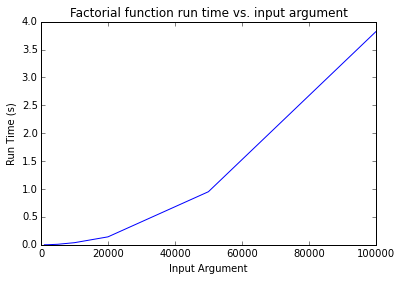

In [4]:
%matplotlib inline

from matplotlib import pyplot as plt
from time       import clock
from numpy      import array

test_vals = array([1, 2, 5, 10, 20, 50, 100]) * 1e3
run_times = []
results   = []
for i in test_vals:
    start = clock()
    results.append(factorial(i))
    run_times.append(clock() - start)
plt.plot(test_vals, run_times)
plt.title("Factorial function run time vs. input argument")
plt.xlabel("Input Argument")
plt.ylabel("Run Time (s)")


The problem is the run time of the factorial function is increasing exponentially with increasing input argument value, and we are sending in some really large values! We need to eliminate those large factorials.

[Back to Contents](#contents)

## <a id="Approximating-the-Binomial-Distribution">Approximating the Binomial Distribution</a>

Consider, for $n$ very large and $m$ very small (i.e. - the conditions we'd expect for a well designed serial communications link):

$$\frac{n!}{(n-m)!} = \frac{n(n-1)(n-2)\cdots1}{(n-m)(n-m-1)\cdots1} = n(n-1)(n-2)\cdots(n-m+1) \approx n^m$$

Let's use this to approximate the Binomial Distribution in a way that gets rid of those large factorials:

$$P(m) = \frac{(np)^m}{m!}(1-p)^{n-m}$$

(Note that we've simplified our notation: from now on, it will be understood that $P(m)$ is the probability of observing $m$ errors in $n$ bits, and that $p$ is the probability that any particular bit will be erroneous.)

Let's code this new expression up and give it a try...

In [5]:
def prob2(m):
    'Uses approximation to eliminate large factorials.'
    
    return pow(kNumBits * kBER, m) * pow((1 - kBER), (kNumBits - m)) / factorial(m)
    
for m in range(3):
    print "P(%d):" % m, prob2(m)


P(0): 0.367887579387
P(1): 0.367887579388
P(2): 0.183943789694


And we have solved our run time problems; yeah!

[Back to Contents](#contents)

## <a id="Poisson-Distribution">Poisson Distribution</a>

Now, that expression, $(1-p)^{n-m}$, has a huge exponent. Maybe, there's even more run time to be saved? Let's find an approximation for it and see if that helps.

Consider, for $p$ very small:

$$(1 - p)^{n-m} = \frac{(1 - p)^n}{(1 - p)^m} \approx (1 - p)^n \approx e^{-np}$$

(Recall that:

$$e^x = \sum_{k=0}^\infty\frac{x^k}{k!}$$

$$e^{-x} = 1 - x + \frac{x^2}{2} - \frac{x^3}{6} + \cdots \approx 1 - x \quad \text{, for x very small.)}$$

Let's work this further approximation into our probability expression:

$$P(m) = \frac{(np)^m}{m!}e^{-np}$$

We have arrived at the well known [Poisson Distribution](http://en.wikipedia.org/wiki/Poisson_distribution), which is used almost exclusively in the serial communication industry to estimate link BER.

Let's code this up and see if it works...

In [6]:
from numpy import exp

def prob3(m):
    'Uses a further approximation to eliminate large exponential term.'
    
    return pow(kNumBits * kBER, m) * exp(-kNumBits * kBER) / factorial(m)
    
for m in range(3):
    print "P(%d):" % m, prob3(m)



P(0): 0.367879441171
P(1): 0.367879441171
P(2): 0.183939720586


Okay, that worked, as well. I wonder which one is faster...

In [7]:
kNumTrials = 1000000

start = clock()
for i in range(kNumTrials):
    prob2(1)
print "Partial approximation took %e seconds per run." % ((clock() - start) / kNumTrials)

start = clock()
for i in range(kNumTrials):
    prob3(1)
print "Full    approximation took %e seconds per run." % ((clock() - start) / kNumTrials)


Partial approximation took 1.348520e-06 seconds per run.
Full    approximation took 2.169107e-06 seconds per run.


Since the partial approximation runs approximately twice as fast and represents a smaller deviation from the true answer, we'll use it going forward.

[Back to Contents](#contents)

## <a id="Confidence-in-Estimation">Confidence in Estimation</a>

Now, let's try to answer the following question:

**If I go into the lab and observe my link operate error free for $10^{12}$ bits, what can I say about my link?**

Many younger engineers use the following faulty reasoning when answering this question:

"Since I observed my link operate error free for $10^{12}$ bits, I know that the worst case possibility is that I had observed it for one additional bit and observed an error."

This leads them to believe that the worst possible BER their link could ever exhibit is:

$$BER \leq \frac{1}{10^{12}+1} \approx 10^{-12}$$

There are two faults in this line of reasoning:

  - That is *not* the worst case possibility; one that is worse is having observed the link for *two* extra bits and having them both be erroneous. In that case, we'd claim our BER was $\leq 2\cdot10^{-12}$, a $100\%$ error, relative to our previous claim!
  - We can't be certain that, if we made another $10^{12}$ bit observation, we wouldn't observe an error.

So, as well as giving someone our *estimate* of our link BER, we also need to quanitfy our *confidence* in that estimate. How do we do that?

Hint: "I'm pretty sure" is *not* the answer!

Well, what if we were to invent and precisely define a new term: *confidence interval*?  
(We use the new, two word phrase, in order to clearly delineate our meaning from that of the English word, *confidence*.)

$$CI = Pr(m > \hat{m} \mid BER > \widehat{BER})$$

or, in English: My confidence in my estimate is simply the probability that I would have observed more errors than I did, if the BER were worse than I'm telling you it is.

If we start down the path of evaluating the expression, above, we quickly arrive at a dead end, when we have to evaluate an infinite sum (from $\hat{m} + 1$ to infinity). While some of these infinite sums often converge to nice, closed form solutions, not so in this case. So, instead, we take advantage of a certain truism in probability theory:

$$Pr(E) = 1 - Pr(\bar{E})$$

or, in English: The probability of an event occuring is equal to one minus the probability of its complement occuring. Using this, we're able to rewrite our expression defining our confidence interval, *CI*, in a way that leads to a sum, which we *can* evaluate:

$$CI = 1 - Pr(m \leq \hat{m} \mid BER > \widehat{BER})$$

Now, we only need to sum from $m=0$ to $m=\hat{m}$. Since $\hat{m}$ is, typically, quite small when characterizing serial communication links, this calculation is quite manageable. Let's code it up and calculate our confidence interval for several test cases...

In [8]:
# Redefine our probability calculation function to take in 'n' and 'p' as arguments.
def prob2(m, n=kNumBits, p=kBER): # By giving n and p the proper defaults, we avoid breaking older client code.
    """
    Calculate the probability of observing m errors in a stream of n bits, given link BER p.
    
    Uses approximation to eliminate large factorials.
    """
    
    return pow(n * p, m) * pow((1 - p), (n - m)) / factorial(m)

# Define our confidence interval calculation function.
def conf_int(m_hat, n, ber):
    """
    Calculate the confidence interval of a BER estimation.
    
    Inputs:
      - m_hat  Number of errors observed.
      - n      Number of bits received.
      - ber    Estimate of link bit error ratio.
      
    """
    
    return 1 - sum(prob2(m, n, ber) for m in range(m_hat + 1))

# Calculate the actual confidence interval of our junior engineer's claim.
print "Confidence in claim, 'BER <= 1e-12', after observing no errors in 1e12 received bits:", conf_int(0, 1e12, 1.e-12)


Confidence in claim, 'BER <= 1e-12', after observing no errors in 1e12 received bits: 0.632112420613


And we see that the confidence interval of our young engineer's claim is only 63%!  
Now, before she read this, what do you suppose her response might have been, if pressed by upper management to "quantify her certainty"? Do you think she might have said something like, "I'm 99% certain in my claim."? How often have you heard a peer say something like that, without any way to defend the number they used? Too often, perhaps?

**Dave's Lemma: Baseless quantification of certainty in engineering claims is partially responsible for Space Shuttles blowing up and bridges collapsing.**

PLEASE, DON'T CONTRIBUTE TO THIS!

[Back to Contents](#contents)

## <a id="Measurement-Precision">Measurement Precision</a>

Now, let's see how our confidence interval improves, as we observe the link operating error-free for longer durations...

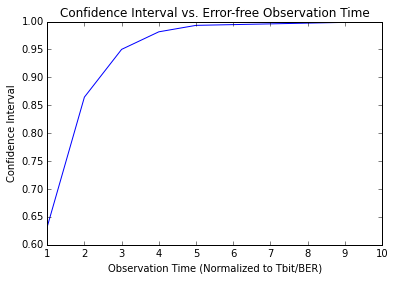

In [9]:
# Plot confidence interval vs. error-free observation time.
intervals = [1, 2, 3, 4, 5, 10] # Numbers are normalized to the quantity '1/BER' bits.
cis       = []
for interval in intervals:
    cis.append(conf_int(0, interval * kNumBits, kBER))
plt.plot(intervals, cis)
plt.title("Confidence Interval vs. Error-free Observation Time")
plt.xlabel("Observation Time (Normalized to Tbit/BER)")
plt.ylabel("Confidence Interval")


As you can see, it requires observing 5e12 error-free bits, before we can claim that we have a 1e-12 BER, with 99% certainty.

Now, what happens if we observe an error? Let's run a slightly modified version of the code, above, and find out:

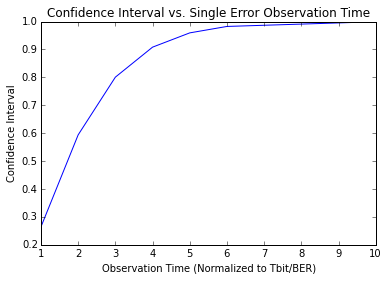

In [10]:
# Plot confidence interval vs. single error observation time.
intervals = [1, 2, 3, 4, 5, 6, 10] # Numbers are normalized to the quantity '1/BER' bits.
cis       = []
for interval in intervals:
    cis.append(conf_int(1, interval * kNumBits, kBER))
plt.plot(intervals, cis)
plt.title("Confidence Interval vs. Single Error Observation Time")
plt.xlabel("Observation Time (Normalized to Tbit/BER)")
plt.ylabel("Confidence Interval")


We see that we need to extend our observation time to 6 normalized time units, in order to achieve the same level of confidence in our estimate of the BER. This is intuitively satisfying, as we observed an error afterall.

What if we ran a really long test? Say, overnight, or maybe even a few days. If our link is really running somewhere near a BER of $10^{-12}$, we'd expect to observe a significant number of errors. What does this increase in observation time and observed number of errors do to our *Confidence Interval* curve? Let's find out:

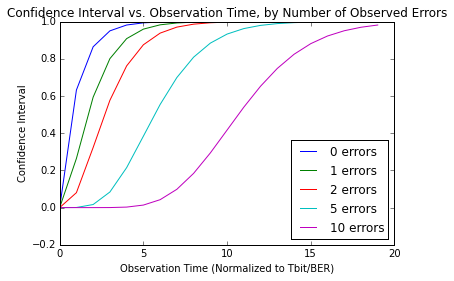

In [11]:
# Plot confidence interval vs. observation time, for several different numbers of observed errors.
errors    = [0, 1, 2, 5, 10]
intervals = range(20)             # Numbers are normalized to the quantity '1/BER' bits.
ciss      = []
for error in errors:
    cis = []
    for interval in intervals:
        cis.append(conf_int(error, interval * kNumBits, kBER))
    ciss.append(cis)
for (error, cis) in zip(errors, ciss):
    plt.plot(intervals, cis, label="{} errors".format(error))
    plt.title("Confidence Interval vs. Observation Time, by Number of Observed Errors")
    plt.xlabel("Observation Time (Normalized to Tbit/BER)")
    plt.ylabel("Confidence Interval")
    plt.legend(loc="lower right")


At first glance, we see what we expected: If we observe more errors, then we must observe the link for a longer time, before claiming a BER better than $10^{-12}$ with confidence greater than 99%. But, notice something else, too: If we increase the number of observed errors by a factor of 10 (i.e. - going from the "1 errors" to the "10 errors" case in the plot, above), we only need to increase our observation time by, roughly, a factor of 3 (i.e. - from 6 normalized time units to approximately 19), in order to quote our BER estimate with the same confidence!

This is rather remarkable and merrits further investigation. It seems to suggest that observations involving more errors are somehow more *precise* than those involving fewer errors. Can we develop a stronger, and more quantitative, sense of this, by approaching the problem from a slightly different direction? Let's try...

Consider what our options are, after observing our link run error free for $5 * 10^{12}$ bits. We know we can claim a BER better than $10^{-12}$ with confidence greater than 99%. However, there are, actually, an infinite number of other claims we can make, all of which are mathematically valid. Here are just a few:

In [12]:
bers = [1e-11, 1e-12, 1e-13]
for ber in bers:
    print "BER better than {} with confidence greater than {}".format(ber, conf_int(0, 5 * kNumBits, ber))
    

BER better than 1e-11 with confidence greater than 1.0
BER better than 1e-12 with confidence greater than 0.993261307685
BER better than 1e-13 with confidence greater than 0.393563631852


Let's see what this trend looks like when plotted, using several different values for the number of observed errors. For each value chosen, we'll adjust the observation time, so as to just provide 99% confidence in a BER estimate of 10e-12. And, in that way, we hope to be doing an "apples to apples" comparison. We'll produce two plots:
- One zoomed in, to check our 99% alignment.
- One full scale, to see the nature of the whole curves.


(0.0, 1e-12, -0.20000000000000001, 1.0000000000000002)

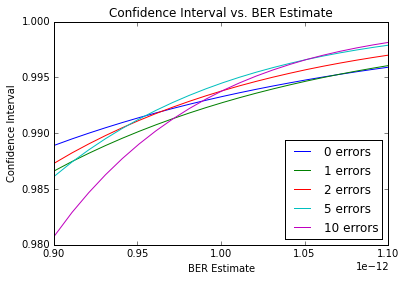

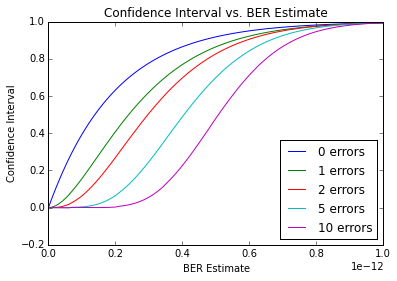

In [13]:
from numpy import arange

errors = [0, 1, 2,  5, 10]
times  = [5, 7, 9, 14, 21]
bers   = arange(1e-15, 2e-12, 1e-14)
ciss   = []
for (error, time) in zip(errors, times):
    cis = []
    for ber in bers:
        cis.append(conf_int(error, time * kNumBits, ber))
    plt.figure(1)
    plt.plot(bers, cis, label="{} errors".format(error))
    plt.figure(2)
    plt.plot(bers, cis, label="{} errors".format(error))
    ciss.append(cis)
    
plt.figure(1)
plt.title("Confidence Interval vs. BER Estimate")
plt.xlabel("BER Estimate")
plt.ylabel("Confidence Interval")
plt.legend(loc="lower right")
plt.axis(ymin=0.98, xmin=0.9e-12, xmax=1.1e-12)

plt.figure(2)
plt.title("Confidence Interval vs. BER Estimate")
plt.xlabel("BER Estimate")
plt.ylabel("Confidence Interval")
plt.legend(loc="lower right")
plt.axis(xmax=1e-12)

From the first plot, above, we can see that we've done a good job of normalizing the observation times, as all 5 curves fall within, approximately, a +/- 0.1% range, regarding the confidence of a 1e-12 BER estimate.

The second plot, above, shows us something interesting: the steepness of the active parts of the plots appears to be increasing, as we increase the number of observed errors. This is important, because it limits, quantitatively, the range of BER estimates that are "interesting". For instance, if we decide that the usefulness of any one of the curves, above, is limited to that range of BER estimates for which it provides a confidence interval in the range (0.70, 0.99), then we can plot this "usefulness range" as a function of observation time:


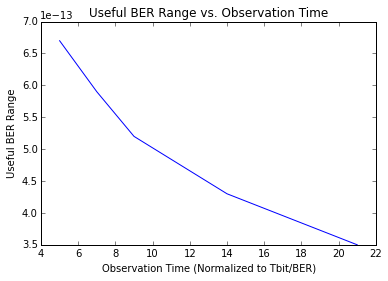

In [14]:
from numpy import where

ranges = []
for cis in map(array, ciss):
    inrange = map(lambda x: (x > 0.70) and (x < 0.99), cis)
    idxs = where(inrange)[0]
    ranges.append(bers[idxs[-1]] - bers[idxs[0]])
plt.plot(times, ranges)
plt.title("Useful BER Range vs. Observation Time")
plt.xlabel("Observation Time (Normalized to Tbit/BER)")
plt.ylabel("Useful BER Range")


Another interpretation of this is that longer observation periods yield more *precise* measures of system BER.

[Back to Contents](#contents)

## <a id="Expectation">Expectation</a>

Now, let's go back a few steps and consider what our *expectation* is, regarding the number of errors we observe in any given observation period. This has a very simple and precise mathematical defintion:

$$
E[x] = np_x
$$

where $E[x]$ is the expected number of observed errors, $n$ is the number of bits observed, and $p_x$ is the probability that any bit is erroneous. If we tabulate this expected number of observed errors against the actual number of observed errors, for the 5 different cases above, we get:

 N |E[x]|N / E[x]
:-:|:--:|:------:
 0| 5|0
 1| 7|0.14
 2| 9|0.22
 5|14|0.36
10|21|0.48

What we find is that, if we are willing to observe the link for longer periods of time, then the actual number of errors we observe can come closer to our expected number of errors while still providing the same level of confidence in our BER estimate.

[Back to Contents](#contents)

## <a id="scipy.stats.poisson">An alternative library function for calculating the Poisson distribution.</a>

Now, what about an extreme case? The following data  were taken from an actual system running in a lab for 18 hours at a line rate of 7.8 Gbps:

- Bits observed: 527.1e12
- Errors observed: 373

What can we infer about the BER of this system? Let's find out...

In [15]:
cis = []
for ber in bers:
    cis.append(conf_int(373, 527.1e12, ber))
plt.plot(bers, cis)
plt.title("Confidence Interval vs. BER Estimate")
plt.xlabel("BER Estimate")
plt.ylabel("Confidence Interval")


OverflowError: long int too large to convert to float

Unfortunately, we can't use our *prob2()* or *prob3()* functions with this large a number of observed errors. However, we have an alternative. The *scipy.stats* module contains a member: *poisson*. And that member offers a *probability mass function* (pmf) calculator, which is robust against large observed error numbers.

Note: The *pmf* is what we are calculating in our *prob2()* and *prob3()* functions defined, above. And recall that our *prob3()* function was shown to be the *Poisson Distribution*.

(5e-13, 1e-12, -0.20000000000000001, 1.0000000000000002)

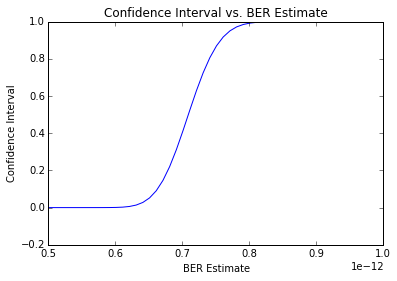

In [16]:
from scipy.stats import poisson

# Define a new confidence interval calculation function, which uses scipy.stats.poisson.
def conf_int2(m_hat, n, ber):
    """
    Calculate the confidence interval of a BER estimation.
    
    Inputs:
      - m_hat  Number of errors observed.
      - n      Number of bits received.
      - ber    Estimate of link bit error ratio.
      
    """
    
    return 1 - sum(poisson.pmf(m, n * ber) for m in range(m_hat + 1))

cis = []
for ber in bers:
    cis.append(conf_int2(373, 527.1e12, ber))
plt.plot(bers, cis)
plt.title("Confidence Interval vs. BER Estimate")
plt.xlabel("BER Estimate")
plt.ylabel("Confidence Interval")
plt.axis(xmin=0.5e-12, xmax=1e-12)


It appears that our system is running at a BER slightly better than 1e-12 (using our standard 99% confidence threshold). And this is what our BERTScope reports, as well.

Now, how does the precision of this measurement compare with our previous hypothetical cases? In order to answer that question, we calculate the *useful BER estimate range*, just as before:

In [17]:
inrange = map(lambda x: (x > 0.70) and (x < 0.99), cis)
idxs = where(inrange)[0]
print "Useful BER estimate range: {}".format(bers[idxs[-1]] - bers[idxs[0]])


Useful BER estimate range: 6e-14


And we see that the useful BER estimate range is less than (and, therefore, the precision greater than) the previous hypothetical cases, by an order of magnitude. (The lowest value plotted in the *Useful BER Range vs. Observation Time* plot, above, is 3.5e-13.) This increase in precision is a direct result of the lengthened observation time.

## <a id="Conclusion">Conclusion</a>

In conclusion, we have precisely defined what we mean by "confidence" in our estimate of a system's bit error ratio (BER). Further, we have shown that the measurement of a system's BER becomes more precise, as the observation time is lengthened. And, finally, we have shown that, as we lengthen observation time, the allowed number of observed errors grows closer to our expectation for this number, while maintaining a consistent level of confidence in our BER estimate.

[Back to Contents](#contents)